In [30]:
import torch
from torchvision import datasets, transforms
# transform -> preprocess before fed to the network
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

In [38]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,),(.5,))])
# totensor는 0~255의 numpy값을 0과 1 데이터 형태로 구분한다. 즉, 값이 0 아닌 건 다 1로 변환해 처리한다는 소리인듯
# normalize는 [image channel, image width, image height] 값을
# 첫 번째 bracket에는 normalize에 사용할 mean값을,
# 두 번째 bracket에는 center diviation.

# 여기서 .5를 쓴 이유는? 
# 최종적으로 만들고 싶은 결과는 range 0~1이 아니라 range -1~1 이기 때문. 
# 예컨대 0은 (0-.5)/.5 = -1로 최종 변환된다. 1은 (1-.5)/.5 = 1로 변환됨.

# normalization은 본질적으로 reduce skewedness and distortion within dataset. (more efficient learning process)


train_dataset = datasets.MNIST(root='./data', train=True, download = True, transform = transform)
# train=True는 training용 데이터셋임을 나타낸것
# 현재 데이터는 28 * 28 픽셀 이미지. 다시말해 2 dim numpy array이다.



# 60000개의 dataset을 한 번 학습할 때마다 1 epoch : 너무 느림
# 대신 이 중 몇 개만을 추려서 한 번 학습 -> epoch 증가하는 형태를 쓴다. 그게 training_loader의 의의
# batch size가 100이면, 600번의 batch가 돌면 1 epoch임
# shuffle을 해주는 이유는 혹시나 있을 local min을 방지하기 위해서.
training_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100, shuffle=True)

In [39]:
def image_convert(tensor):
    # 원래 이미지로 돌려놓기 위한 함수
    
    image = tensor.clone().detach().numpy() # create new copy + detach
    # [color channel, width, height] 값으로 구분됨. 엠니스트의 경우 1 * 28 * 28
    
    image = image.transpose(1,2,0) # 28*28*1로 변경
    image = image * np.array((.5,.5,.5)) + np.array((.5,.5,.5)) #정규화한 작업을 풀어주는 거 같은데...

    # 학습을 위해 0~1 값을 -1~1로 변경했으므로, 이걸 되돌려 준다
    image = image.clip(0,1) # min을 0, max를 1로 변경해주는 것
    return image

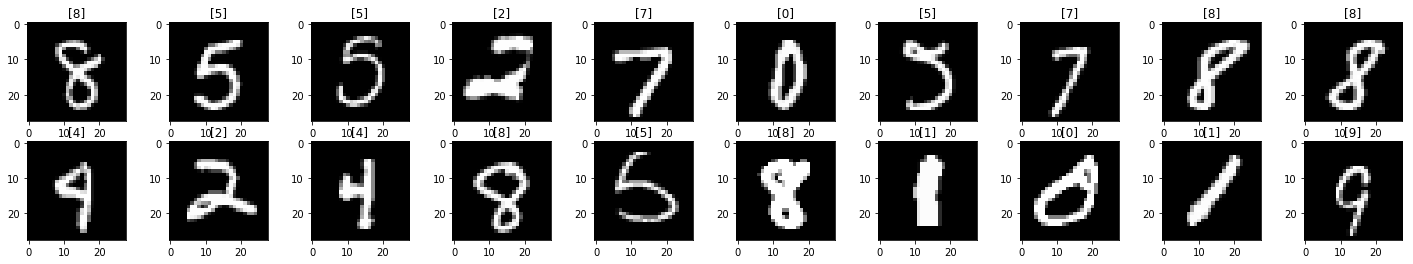

In [40]:
dataiter = iter(training_loader)
# create the object that allows us to go through the iterable One element at a time.
# .next() 로 접근 가능함.
# 이 데이터셋은 image, label 두 개의 데이터를 반환
images, labels = dataiter.next()
images.shape
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1) # 2 row, 10 columns per row, 마지막은 index. 
    #이 subplot에 총 20개의 공간이 있기 때문에 index는 1~20 사이값이어야 함
    plt.imshow(image_convert(images[i]))
    ax.set_title([labels[i].item()])


In [41]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_1, hidden_2, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_1)
        self.linear2 = nn.Linear(hidden_1, hidden_2)
        self.linear3 = nn.Linear(hidden_2, output_size)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # score값을 말하기도 하는데, multiclass 분류에서 crossentropy 함수 작동을 위해 필요하다.
        return x
    

In [42]:
model = Classifier(28*28*1, 125, 65,10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [43]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = .01)

In [44]:
epochs = 12

losses = []
correct_history = []
for e in range(epochs):
    running_loss = 0
    running_correct = 0
    for images, labels in training_loader:
        images = images.view(images.shape[0],-1)
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        _, pred = torch.max(outputs,1) # 튜플이 나올 때 첫번째 값은 image 연산결과고, 두 번째가 label값이 될 것.
        # max(output,1)에서 1은 dim으로, 1이기 때문에 각 row별 최대값을 구함.

#  tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
#         [ 1.1949, -1.1127, -2.2379, -0.6702],
#         [ 1.5717, -0.9207,  0.1297, -1.8768],
#         [-0.6172,  1.0036, -0.6060, -0.2432]])
# torch.max(a, 1)
# (tensor([ 0.8475,  1.1949,  1.5717,  1.0036]), tensor([ 3,  0,  0,  1]))

        running_correct +=torch.sum(pred == labels.data)
        running_loss += loss.item()
        
    else:
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_correct.float() / len(training_loader)
        losses.append(epoch_loss)
        correct_history.append(epoch_acc)
        print('training loss: {:4f}, Accuracy: {:4f}'.format(epoch_loss, epoch_acc))
    

training loss: 0.372196, Accuracy: 88.333336
training loss: 0.217179, Accuracy: 93.573334
training loss: 0.201254, Accuracy: 94.058334
training loss: 0.182376, Accuracy: 94.688332
training loss: 0.176675, Accuracy: 94.936668
training loss: 0.174092, Accuracy: 94.933334
training loss: 0.175444, Accuracy: 94.986664
training loss: 0.167102, Accuracy: 95.336670
training loss: 0.170577, Accuracy: 95.196663
training loss: 0.153446, Accuracy: 95.683334
training loss: 0.159138, Accuracy: 95.584999
training loss: 0.159454, Accuracy: 95.584999


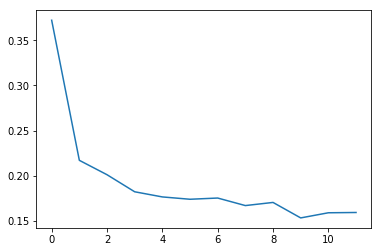

In [45]:
plt.plot(losses, label='training_loss')